In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from __future__ import (absolute_import, division, print_function, unicode_literals)
import warnings
import time
warnings.simplefilter('ignore')
# plt.rcParams["figure.figsize"] = (10, 6)
pd.options.display.max_columns = 190
pd.options.display.max_rows = 200

from datetime import datetime, timedelta

## Data preparation

In [13]:
#     1st priority
#      $1  id
#      $2  date
#      $3  action type (tracker, event, impression, click. visibility)
#      $11 Campaign name   
#      $13 site name
#      $15 Insertion name (pre-roll, multi-roll etc)
#      $18 conv type (post-click, post-event, post-imp)
#      $20 Conversion page name ([Microlax]_Visitors more 30 sec)


#     2nd priority
#      $7  Project name
#      $17 Creative name 
#      $33 Last action date-hour 

In [14]:
!cat ./data/all_conv.csv | awk 'BEGIN{FS=",";OFS=","}{print $1,$2,$3,$11,$13,$15,$18,$20}' > ./data/all_conv.prep1.csv

In [15]:
# visitors
conv_list_visitors = ['Acuvue Site Visitors']

# thankyoupage
conv_list = ['Acuvue Visitors thank you page']

# all conversions
conv_list = [
'Acuvue Register gor Define FVT',
'Acuvue Register gor Generic FVT',
'Acuvue Site Visitors',
'Acuvue Visit DD related pages',
'Acuvue Visit DEFINE related pages',
'Acuvue Visit ECP locator',
'Acuvue Visit General Education article',
'Acuvue Visit more 1 min last',
'Acuvue Visit RU related pages',
'Acuvue Visit with BR <80',
'Acuvue Visitors certificate',
'Acuvue Visitors thank you page',
'Acuvue visitors thankyou page_Oasys 1-day'
]

In [16]:
def grep_ids(conversion_list_):
    ids = pd.DataFrame()
    for i in conv_list:   
        !cat ./data/all_conv.csv | grep "$i" > ./data/ids.grep                       # Grep
        !cat ./data/ids.grep | awk 'BEGIN{FS=",";OFS=","}{print $1}' > ./data/ids    # awk 
        ids_1 = pd.read_csv('./data/ids', header=None, names=['ids'])
        ids = pd.concat([ids, ids_1])   
    !rm ./data/ids.grep    
    return set(ids.ids)

In [17]:
%%time
# visitors_ids = grep_ids(conv_list_visitors)
ids = grep_ids(conv_list)

CPU times: user 405 ms, sys: 237 ms, total: 642 ms
Wall time: 5.59 s


In [18]:
%%time
df = pd.read_csv('./data/all_conv.prep1.csv', names = ['customer_id','date','action_type','Campaign','channel', 'insertion_name', 'type', 'conv_name'])
df = df[df.customer_id.isin(ids)]
df.channel[df.channel.notnull()] = df.channel[df.channel.notnull()].apply(lambda x: x.split('(')[0])
#df = df.sort_values(by=['customer_id', 'date'])

mask = (df['Campaign'] != 'Acuvue_OLV_Jan-Feb_2018')  # удалим другие РК, если не хотим учитывать показы "бренда"
df.Campaign[mask] = np.NaN
df = df[df.channel.notnull()]    
df = df[df.Campaign.notnull()]   

df = df[(df.action_type == 'impression')
        | (df.action_type == 'tracker') | 
        (df.action_type == 'click') | (df.action_type == 'event')]
df.replace(to_replace='tracker', value=1, inplace = True)
df.replace(to_replace='impression', value=0, inplace = True)
df.replace(to_replace='click', value=0, inplace = True)
df.replace(to_replace='event', value=0, inplace = True)
df = df.rename(columns={"action_type": "conversion"})

CPU times: user 1.47 s, sys: 113 ms, total: 1.59 s
Wall time: 1.59 s


In [20]:
def get_path_no(df):
    df = df.copy()
    df['path_no'] = df.groupby(by='customer_id').conversion.cumsum()
    groupby_cumsum_shift = df.groupby(by='customer_id').path_no.shift()
    df['path_no'] = np.where(groupby_cumsum_shift.isnull()==True, 0, groupby_cumsum_shift).astype(int)+1
    return df

In [23]:
df = get_path_no(df)

In [24]:
#saving
df.to_csv('./data/df_ready.csv', index= None)
# to R format
df[['customer_id','date','channel','conversion']].to_csv('./data/_R_data', index=None)

## Data Analysis

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from __future__ import (absolute_import, division, print_function, unicode_literals)
import warnings
import time
warnings.simplefilter('ignore')
# plt.rcParams["figure.figsize"] = (10, 6)
pd.options.display.max_columns = 190
pd.options.display.max_rows = 200

from datetime import datetime, timedelta

In [26]:
dff = pd.read_csv('./data/df_ready.csv')

In [27]:
# drop null chains (C1 > C2 > Null)
dff['id_path'] = dff.customer_id.astype('str') + '_' + dff.path_no.astype('str')
vector = dff.groupby('id_path').conversion.sum() == 0
bad_ids = set(vector[vector].index)
dff = dff[~dff.id_path.isin(bad_ids)]
dff.drop('id_path', axis=1, inplace=True)
dff = get_path_no(dff)

### Repeated conversion

In [28]:
def get_repeated_conv(df, time_delta=12, column_name='repeated_conversion'):
    """
    добавляет колонку repeated_conversion - 1 если человек совершил конверсию спустя time_delta часов
    """
    df = df.copy()
    df.date = pd.to_datetime(df.date)
    groupby = df[df.conversion == 1].groupby(by='customer_id')
    vector = groupby.date.max() - groupby.date.min() > timedelta(hours=time_delta)    
    good_ids = vector[vector==True].index
    df[column_name] = np.where((df.customer_id.isin(good_ids)) & (df.conversion == 1) & (df.path_no ==1), 1, 0)
    return df

In [29]:
dff = get_repeated_conv(dff, time_delta=0.5)

In [30]:
first = dff[dff.path_no == 1].conversion.sum()
repeat = dff[dff.repeated_conversion == 1].conversion.sum()
print('Первых посещений: {}, \nповторных: {}\n'.format(first, repeat))
print('%_first: {:.2%}, \n%_repeat: {:.2%}'.format(first/first, repeat/first))

Первых посещений: 11496, 
повторных: 371

%_first: 100.00%, 
%_repeat: 3.23%


In [31]:
print("видим что больше всего повторных конверсий у ГПМД, но надо разделить на общее число показов и получить CR_repeated. У кого выше, тот эффективнее по повторным конверсиям")
dff[dff.repeated_conversion == 1].channel.value_counts()  
# next steps: показать гистограмму возвращений по дням (сколько дней проходит от 1 до 2 визита). Нужно оставить только первую и повторную конверсию, groupby и вычесть время 

видим что больше всего повторных конверсий у ГПМД, но надо разделить на общее число показов и получить CR_repeated. У кого выше, тот эффективнее по повторным конверсиям


GPMD              208
Target.mail.ru     92
Vesti.ru           33
filmpro.ru         12
RussiaTV.ru        10
M24.ru              9
Buzzoola            5
Youtube.com         2
Name: channel, dtype: int64

### Frequency analysis

In [32]:
df_path_1 = dff[dff.path_no == 1]
df_path_2 = dff[dff.path_no == 2]

In [33]:
def get_frequency(df):
    """
    частота - среднее число импов у айдишек
    # N_impr - сумма показов
    # uniq - охват, количество уникальных айдишек.
    # в рекламе есть формула freq = N_impr / uniq но здесь мы не совпадаем на 100% т.к. эта формула грубая - не учитывает показы других каналов. А наши оценки точные.  
    """
    print('freq' + '\t' + 'N_impr' + '\t' + 'uniq' + '\t' + 'Channel')
    for i in df.channel.unique():
        dfi = df[(df.channel == i) & (df.conversion == 0)]
        count_i = dfi.groupby('customer_id').channel.count()
        n_uniq = len(dfi.customer_id.unique())
        print("{0:.4f}".format(count_i.mean()) +'\t' + str(count_i.sum()) +'\t' + str(n_uniq) +'\t' + i)

In [34]:
get_frequency(df_path_1)

freq	N_impr	uniq	Channel
3.9302	9118	2320	Target.mail.ru
1.4564	1385	951	RussiaTV.ru
2.4506	1811	739	filmpro.ru
1.3056	1239	949	Vesti.ru
1.5389	1662	1080	M24.ru
1.0000	3	3	Youtube.com
10.4416	54171	5188	GPMD
5.8500	468	80	Buzzoola


In [35]:
def get_frequency_alt(df, n=None, by_channels=False):
    """
    считает стандартный график распределения по частотам. 
    параметр n указывает максимальную частоту, например n=3 сделает частоты 1,2 и 3+ 
    если by_channels=True то делает разбивку по каналам - можно выявить кто сильнее отклонялся от медиа-плана
    """
    dfr = df[(df.conversion == 0) & (df.path_no == 1)][['customer_id','channel']]
    if by_channels==False:
        dfr.channel = 'frequency'
    else:
        pass
    
    a = pd.DataFrame()
    for i in dfr.channel.unique():
        dfi = dfr[dfr.channel == i]
        frequency = dfi.groupby('customer_id').customer_id.count().value_counts()
        result = pd.DataFrame(data = {i: frequency}).sort_index()
        a = pd.concat([a,result], axis=1)
    
    if isinstance(n, int):
        plus = pd.Series(a[n-1:].sum(), name=str(n)+'+')
        a = a[:n-1].append(plus)
    else:
        pass
    
    return a.fillna(0)

In [36]:
get_frequency_alt(df_path_1, n=10, by_channels=False)

,frequency
1,4271
2,589
3,1057
4,802
5,554
6,480
7,326
8,81
9,149
10+,2799


### Deep conversions

In [37]:
def get_deep_conv(df, n=2, time_delta=0.5):
    """ 
    n отвечает за глубину просмотра. 
    например если n=3 то конверсия считается глубокой если 3 или более страницы за посещение
    timedelta указывает время сессии (в часах)
    """
    df = df.copy()
    df.date = pd.to_datetime(df.date)
    df['conv_alt'] = df['conversion']
    df['shift_date'] = pd.to_datetime(df[df.conv_alt == 1].groupby(by='customer_id').date.shift(-(n-1)))   # -2 значит минимум три действия должны быть в течение 30 минут
    df['Difference'] = df['shift_date'].sub(df['date'], axis=0)
    df['deep_conversion'] = np.where((df.conversion == 1) & (df.Difference < timedelta(hours=time_delta)), 1, 0)
    df.drop(['conv_alt', 'shift_date', 'Difference'], axis=1, inplace=True)
    return df

In [38]:
dff = get_deep_conv(dff, n=2)
first = dff[dff.path_no == 1].conversion.sum()
deep = dff[(dff.conversion == 1) & (dff.deep_conversion == 1) & (dff.path_no ==1)].conversion.sum()
print('Первых посещений: {}, \nГлубоких (2+ страниц за полчаса в первое посещение): {}'.format(first, deep))
print('%_first: {:.2%}, \n%_2+: {:.2%}'.format(first/first, deep/first))

Первых посещений: 11496, 
Глубоких (2+ страниц за полчаса в первое посещение): 3005
%_first: 100.00%, 
%_2+: 26.14%


In [39]:
dff = get_deep_conv(dff, n=3)
first = dff[dff.path_no == 1].conversion.sum()
deep = dff[(dff.conversion == 1) & (dff.deep_conversion == 1) & (dff.path_no ==1)].conversion.sum()
print('Первых посещений: {}, \nГлубоких (3+ страниц за полчаса в первое посещение): {}'.format(first, deep))
print('%_first: {:.2%}, \n%_2+: {:.2%}'.format(first/first, deep/first))

Первых посещений: 11496, 
Глубоких (3+ страниц за полчаса в первое посещение): 1588
%_first: 100.00%, 
%_2+: 13.81%


In [40]:
# next steps: есть ли корреляция между глубиной просмотра и "эффективностью"?? т.е.можно ли сказать что если (в данной конкретной РК) у площадки больше глубина, то больше повторных конверсий?

### Page depth

In [41]:
dfx = dff[dff.conversion == 1]
dfx = dfx[['customer_id','date','channel','conversion','path_no']]

In [42]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19191 entries, 1 to 95253
Data columns (total 5 columns):
customer_id    19191 non-null object
date           19191 non-null datetime64[ns]
channel        19191 non-null object
conversion     19191 non-null int64
path_no        19191 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 899.6+ KB


In [43]:
def get_time_from_start(df):
    c = df.groupby('customer_id').date.min()
    datemin = pd.DataFrame({'customer_id': c.index, 'date_min':c.values})
    result = pd.merge(datemin, df, on='customer_id')
    result['time_from_start'] = result.date - result.date_min
    result.drop(['date_min'], axis=1, inplace=True)
    return result

In [44]:
dfx = get_time_from_start(dfx)

In [45]:
#надо пересчитать номер цепочки (для Rostelecom)
dfx = get_path_no(dfx)

In [46]:
def get_page_depth(df, time_delta = 0.5, n=None, by_channels=False):
    """
    считает уников на каждой глубине просмотра 1,2, ..., n+ 
    """
    dfr = df[df.time_from_start < timedelta(hours = time_delta)]   # оставили только первые 30 минут
#     dfr = dfr[~((dfr.conversion == 1) & (dfr.path_no == 1))]   
    
    if by_channels==False:
        dfr.channel = '_'
    else:
        pass

    a = pd.DataFrame()
    for i in dfr.channel.unique():
        dfi = dfr[dfr.channel == i]
        frequency = dfi.groupby('customer_id').customer_id.count().value_counts()
        result = pd.DataFrame(data = {i: frequency}).sort_index()
        a = pd.concat([a,result], axis=1)

    if isinstance(n, int):
        plus = pd.Series(a[n-1:].sum(), name=str(n)+'+')
        a = a[:n-1].append(plus)
    else:
        pass
    
    return a

In [47]:
stat = get_page_depth(dfx, time_delta = 0.5, n=10, by_channels=True)  
stat # видим что на RussiaTV.ru 669 человек сделал глубину просмотра 3

,Target.mail.ru,GPMD,RussiaTV.ru,filmpro.ru,Vesti.ru,M24.ru,Buzzoola,Youtube.com
1,2044.0,4098.0,567.0,443.0,663.0,702.0,48.0,2.0
2,195.0,505.0,184.0,134.0,140.0,193.0,11.0,1.0
3,56.0,259.0,111.0,92.0,87.0,107.0,1.0,NaN
4,8.0,137.0,50.0,44.0,44.0,57.0,3.0,NaN
5,4.0,112.0,17.0,18.0,20.0,27.0,2.0,NaN
6,3.0,43.0,10.0,7.0,9.0,12.0,1.0,NaN
7,2.0,40.0,6.0,7.0,4.0,5.0,NaN,NaN
8,NaN,39.0,5.0,2.0,2.0,1.0,1.0,NaN
9,3.0,32.0,NaN,1.0,NaN,NaN,1.0,NaN
10+,5.0,64.0,0.0,4.0,0.0,0.0,4.0,0.0


In [48]:
# взвешенная средняя глубина по площадкам
for i in stat.columns:
    average_depth = np.average(np.arange(1,11), weights=stat[i])
    print('{:.4}'.format(average_depth) + '\t' + i)

nan	Target.mail.ru
1.646	GPMD
nan	RussiaTV.ru
1.874	filmpro.ru
nan	Vesti.ru
nan	M24.ru
nan	Buzzoola
nan	Youtube.com


In [49]:
# проверить гипотезу: глубина просмотра коррелирует с конверсией

In [50]:
# - оценить сколько показов было сверх оптимальной частоты и потраченные на них деньги
# - интерактивные графики в plotly

In [51]:
dff.to_csv('dff_prepared', index=None)

## Sales Funnel: usefull visit

In [52]:
dff = dff[dff.conversion == 1]  # уберем импы

In [53]:
dff = get_path_no(dff)          # пересчитаем path no

In [54]:
# dff['visit'] = np.where((dff.conv_name == '[J&J] Acuvue Site Visitors') \
# | (dff.conv_name=='[J&J] Acuvue Visit RU related pages') \
# | (dff.conv_name=='[J&J] Acuvue Visit DD related pages') \
# | (dff.conv_name=='[J&J] Acuvue Visit General Education article') \
# | (dff.conv_name=='[J&J] Acuvue Visit ECP locator') \
# | (dff.conv_name=='[J&J] Acuvue Visitors certificate') \
# | (dff.conv_name=='[J&J] Acuvue Visit DEFINE related pages') 
# , 1, 0)
dff['visit'] = np.where(dff.conversion == 1, 1, 0)   # визит будет у всех, кто в конверсиях

In [55]:
# usefull visit если:
# была повторная или глубокая конверсия, или conv_name это какой-то глубокий раздел сайта или заявка

dff['tmp'] = np.where((dff.repeated_conversion == 1) | (dff.deep_conversion == 1) | \
                             (dff.conv_name == '[J&J] Acuvue Register gor Define FVT') | \
                             (dff.conv_name == '[J&J] Acuvue Register gor Generic FVT') | \
                             (dff.conv_name == '[J&J] Acuvue Visitors thank you page') | \
                             (dff.conv_name == '[J&J] Acuvue visitors thankyou page_Oasys 1-day')
                             , 1, 0)
groupby = dff.groupby(by='customer_id')
vector = groupby.tmp.max() == 1    
good_ids = vector[vector==True].index
dff = dff.drop('tmp', axis=1)

dff['usefull_visit'] = np.where((dff.customer_id.isin(good_ids)), 1, 0)


In [56]:
dff['first_visit'] = np.where((dff.visit == 1) & (dff.path_no == 1), 1, 0)
dff['first_usefull_visit'] = np.where((dff.usefull_visit == 1) & (dff.path_no == 1), 1, 0)

In [57]:
dff.first_visit.value_counts()

1    11496
0     7695
Name: first_visit, dtype: int64

In [58]:
dff.first_usefull_visit.value_counts()

0    17280
1     1911
Name: first_usefull_visit, dtype: int64

In [59]:
# заявка - это либо thank_you_page либо thank_you_page_Oasys

dff['tmp'] = np.where((dff.conv_name == '[J&J] Acuvue Visitors thank you page') | \
                      (dff.conv_name == '[J&J] Acuvue visitors thankyou page_Oasys 1-day')
                             , 1, 0)
groupby = dff.groupby(by='customer_id')
vector = groupby.tmp.max() == 1    
good_ids = vector[vector==True].index
dff['final_conversion'] = np.where((dff.customer_id.isin(good_ids)), 1, 0)
dff = dff.drop('tmp', axis=1)

In [60]:
MYLIST = ['[J&J] Acuvue Register gor Define FVT','[J&J] Acuvue Register gor Generic FVT','[J&J] Acuvue Site Visitors','[J&J] Acuvue Visit DD related pages','[J&J] Acuvue Visit DEFINE related pages','[J&J] Acuvue Visit ECP locator','[J&J] Acuvue Visit General Education article','[J&J] Acuvue Visit more 1 min last','[J&J] Acuvue Visit RU related pages','[J&J] Acuvue Visit with BR <80%','[J&J] Acuvue Visitors certificate','[J&J] Acuvue Visitors thank you page','[J&J] Acuvue visitors thankyou page_Oasys 1-day ']
for i in MYLIST:
    print(str(dff[dff.conv_name == i].shape[0]) + '\t' + ' ' + str(i))
    
# принтует количество каждой конверсии из списка

0	 [J&J] Acuvue Register gor Define FVT
45	 [J&J] Acuvue Register gor Generic FVT
13500	 [J&J] Acuvue Site Visitors
1350	 [J&J] Acuvue Visit DD related pages
622	 [J&J] Acuvue Visit DEFINE related pages
1102	 [J&J] Acuvue Visit ECP locator
488	 [J&J] Acuvue Visit General Education article
0	 [J&J] Acuvue Visit more 1 min last
1328	 [J&J] Acuvue Visit RU related pages
0	 [J&J] Acuvue Visit with BR <80%
559	 [J&J] Acuvue Visitors certificate
57	 [J&J] Acuvue Visitors thank you page
0	 [J&J] Acuvue visitors thankyou page_Oasys 1-day 


In [61]:
dff = dff[dff.conversion == 1]

In [62]:
frame = pd.DataFrame()
for i in dff.channel.unique():
    df1 = dff[dff.channel == i]
    a = df1[df1.path_no == 1].shape[0]
    df1 = get_deep_conv(df1, n=2, time_delta=24*30)
    b= df1[df1.path_no == 1][df1.deep_conversion == 1].shape[0]
    df_conv = df1[(df1.conv_name == '[J&J] Acuvue Visitors thank you page') | (df1.conv_name =='[J&J] Acuvue visitors thankyou page_Oasys 1-day')]
    c = df_conv.shape[0]
    dd = pd.DataFrame(data=[a,b,c], columns=[i])
    frame = pd.concat([dd, frame], axis =1)   

In [63]:
print('Sales Funnel by channels')
frame['Total'] = frame.sum(axis=1)
frame.index = ['visit', 'usefull visit', 'conversion']
frame

Sales Funnel by channels


,Buzzoola,GPMD,Youtube.com,M24.ru,Vesti.ru,filmpro.ru,RussiaTV.ru,Target.mail.ru,Total
visit,72,5327,3,1104,969,751,950,2320,11496
usefull visit,28,1404,1,408,337,317,392,357,3244
conversion,4,58,0,0,0,0,0,1,63


In [64]:
# на основании этой таблицы считаем CR и делаем выводы по эффективности
# next steps: посчитать все три конверсии мультитач моделью

## Оптимальная частота

In [65]:
!cat ./data/all_imp.csv | awk 'BEGIN{FS=",";OFS=","}{print $1}' > ./data/all_imp_ids.csv

In [66]:
imp = pd.read_csv('./data/all_imp_ids.csv', header=None, names=['id'])   # только айдишки

In [67]:
%%time
groupby = imp.groupby('id').id.count()

CPU times: user 166 ms, sys: 0 ns, total: 166 ms
Wall time: 169 ms


In [68]:
f1 = groupby[groupby == 1].index
f2 = groupby[groupby == 2].index
f3 = groupby[groupby == 3].index
f4 = groupby[groupby == 4].index
f5 = groupby[groupby == 5].index
f6 = groupby[groupby == 6].index
f7 = groupby[groupby == 7].index
f8 = groupby[groupby == 8].index
f9 = groupby[groupby == 9].index
f10plus = groupby[groupby >= 10].index

In [69]:
total = 0
print('частота\t уников')
for num,f in enumerate([f1,f2,f3,f4,f5,f6,f7,f8,f9,f10plus]):
    print(num+1,'\t', len(f))
    total += (num+1)*len(f)        # общее число показов: 1*f1 + 2*f2 + 3*f3 + 4*f4 и так далее 
print('всего показов:', total)

частота	 уников
1 	 70032
2 	 8527
3 	 1747
4 	 595
5 	 279
6 	 127
7 	 75
8 	 55
9 	 45
10 	 122
всего показов: 99454


In [70]:
def get_funnel(dff, f):
    dff = dff[dff.customer_id.isin(set(f))]
    dff = dff[dff.conversion == 1]
    frame = pd.DataFrame()
    for i in dff.channel.unique():
        df1 = dff[dff.channel == i]
        a = df1[df1.path_no == 1].shape[0]
        df1 = get_deep_conv(df1, n=2, time_delta=24*30)
        b= df1[df1.path_no == 1][df1.deep_conversion == 1].shape[0]
        df_conv = df1[(df1.conv_name == '[J&J] Acuvue Visitors thank you page') | (df1.conv_name =='[J&J] Acuvue visitors thankyou page_Oasys 1-day')]
        c = df_conv.shape[0]
        dd = pd.DataFrame(data=[a,b,c], columns=[i])
        frame = pd.concat([dd, frame], axis =1)   
    frame['Total'] = frame.sum(axis=1)
    frame.index = ['visit', 'usefull visit', 'conversion']
    return frame

In [71]:
for i in [f1, f2, f3, f4]:
    print (get_funnel(dff, f=f1).to_string(index=False))
    print()

GPMD  Buzzoola  Target.mail.ru  filmpro.ru  M24.ru  Vesti.ru  RussiaTV.ru  Total
 226         1              34          17      30        17            4    329
  78         0               4           3       5         4            2     96
   0         0               0           0       0         0            0      0

GPMD  Buzzoola  Target.mail.ru  filmpro.ru  M24.ru  Vesti.ru  RussiaTV.ru  Total
 226         1              34          17      30        17            4    329
  78         0               4           3       5         4            2     96
   0         0               0           0       0         0            0      0

GPMD  Buzzoola  Target.mail.ru  filmpro.ru  M24.ru  Vesti.ru  RussiaTV.ru  Total
 226         1              34          17      30        17            4    329
  78         0               4           3       5         4            2     96
   0         0               0           0       0         0            0      0

GPMD  Buzzoola  Target.ma

In [72]:
# этими табличками анализируем CR по каждой частоте, находим оптимальную f
# можно взять только столбец Total, если площадки отработали +- одинаково

# Сравнение кликеров и post event

In [73]:
#$18 == click
!cat ./data/all_conv.csv | grep -e 'Acuvue Register gor Define FVT' -e 'Acuvue Register gor Generic FVT' -e 'Acuvue Site Visitors' -e 'Acuvue Visit DD related pages' -e 'Acuvue Visit DEFINE related pages' -e 'Acuvue Visit ECP locator' -e 'Acuvue Visit General Education article' -e 'Acuvue Visit more 1 min last' -e 'Acuvue Visit RU related pages' -e 'Acuvue Visit with BR <80' -e 'Acuvue Visitors certificate' -e 'Acuvue Visitors thank you page' -e 'Acuvue visitors thankyou page_Oasys 1-day' | awk 'BEGIN{FS=",";OFS=","}{if ($18 == "click")print $1}' > ./data/ids.ids
ids_cl = pd.read_csv('./data/ids.ids', header=None, names=['ids'])
#$18 == event 
!cat ./data/all_conv.csv | grep -e 'Acuvue Register gor Define FVT' -e 'Acuvue Register gor Generic FVT' -e 'Acuvue Site Visitors' -e 'Acuvue Visit DD related pages' -e 'Acuvue Visit DEFINE related pages' -e 'Acuvue Visit ECP locator' -e 'Acuvue Visit General Education article' -e 'Acuvue Visit more 1 min last' -e 'Acuvue Visit RU related pages' -e 'Acuvue Visit with BR <80' -e 'Acuvue Visitors certificate' -e 'Acuvue Visitors thank you page' -e 'Acuvue visitors thankyou page_Oasys 1-day' | awk 'BEGIN{FS=",";OFS=","}{if ($18 == "event")print $1}' > ./data/ids.ids
ids_ev = pd.read_csv('./data/ids.ids', header=None, names=['ids'])

In [74]:
len(set(ids_cl.ids)), len(set(ids_ev.ids))

(11329, 431)

In [75]:
df_ev = pd.read_csv('./data/all_conv.prep1.csv', names = ['customer_id','date','action_type','Campaign','channel', 'insertion_name', 'type', 'conv_name'])
df_ev = df_ev[df_ev.customer_id.isin(ids_ev.ids)]

df_ev.channel[df_ev.channel.notnull()] = df_ev.channel[df_ev.channel.notnull()].apply(lambda x: x.split('(')[0])
df_ev = df_ev.sort_values(by=['customer_id', 'date'])
mask = (df_ev['Campaign'] != 'Acuvue_OLV_Jan-Feb_2018')  # удалим другие РК, если не хотим учитывать показы "бренда"
df_ev.Campaign[mask] = np.NaN
df_ev = df_ev[df_ev.channel.notnull()]    
df_ev = df_ev[df_ev.Campaign.notnull()]   
df_ev = df_ev[(df_ev.action_type == 'impression') | (df_ev.action_type == 'tracker')]
df_ev.replace(to_replace='tracker', value=1, inplace = True)
df_ev.replace(to_replace='impression', value=0, inplace = True)
df_ev = df_ev.rename(columns={"action_type": "conversion"})
# для event удалим клики, т.к. они учтены в кликерах
bad_ids = set(df_ev[df_ev.type == 'click'].customer_id) 
df_ev = df_ev[~df_ev.customer_id.isin(bad_ids)]
df_ev = get_path_no(df_ev)
# drop null chains
df_ev['id_path'] = df_ev.customer_id.astype('str') + '_' + df_ev.path_no.astype('str')
vector = df_ev.groupby('id_path').conversion.sum() == 0
bad_ids = set(vector[vector].index)
df_ev = df_ev[~df_ev.id_path.isin(bad_ids)]
df_ev.drop('id_path', axis=1, inplace=True)

In [76]:
df_ev.to_csv('post-event_visitors.csv', index=None)

In [77]:
df_click = pd.read_csv('./data/all_conv.prep1.csv', names = ['customer_id','date','action_type','Campaign','channel', 'insertion_name', 'type', 'conv_name'])
df_click = df_click[df_click.customer_id.isin(ids_cl.ids)]

df_click.channel[df_click.channel.notnull()] = df_click.channel[df_click.channel.notnull()].apply(lambda x: x.split('(')[0])
df_click = df_click.sort_values(by=['customer_id', 'date'])
mask = (df_click['Campaign'] != 'Acuvue_OLV_Jan-Feb_2018')  # удалим другие РК, если не хотим учитывать показы "бренда"
df_click.Campaign[mask] = np.NaN
df_click = df_click[df_click.channel.notnull()]    
df_click = df_click[df_click.Campaign.notnull()]   
df_click = df_click[(df_click.action_type == 'impression') | (df_click.action_type == 'tracker')]
df_click.replace(to_replace='tracker', value=1, inplace = True)
df_click.replace(to_replace='impression', value=0, inplace = True)
df_click = df_click.rename(columns={"action_type": "conversion"})
df_click = get_path_no(df_click)
# drop null chains
df_click['id_path'] = df_click.customer_id.astype('str') + '_' + df_click.path_no.astype('str')
vector = df_click.groupby('id_path').conversion.sum() == 0
bad_ids = set(vector[vector].index)
df_click = df_click[~df_click.id_path.isin(bad_ids)]
df_click.drop('id_path', axis=1, inplace=True)

In [78]:
df_click.to_csv('post-click_visitors.csv', index=None)

###########################################################

In [79]:
clickers = pd.read_csv('post-click_visitors.csv')
post_event = pd.read_csv('post-event_visitors.csv')

In [80]:
print('total 1st visitors')
print(len(set(clickers.customer_id)) + len(set(post_event.customer_id)) )

total 1st visitors
11491


In [81]:
# Clickers

In [82]:
dff = clickers

In [83]:
dff = dff[dff.conversion == 1]

In [84]:
frame = pd.DataFrame()
for i in dff.channel.unique():
    df1 = dff[dff.channel == i]
    dff = get_path_no(dff)
    a = df1[df1.path_no == 1].shape[0]
    df1 = get_deep_conv(df1, n=2, time_delta=24*30)
    b= df1[df1.path_no == 1][df1.deep_conversion == 1].shape[0]
    df_conv = df1[(df1.conv_name == '[J&J] Acuvue Visitors thank you page') | (df1.conv_name =='[J&J] Acuvue visitors thankyou page_Oasys 1-day')]
    c = df_conv.shape[0]
    dd = pd.DataFrame(data=[a,b,c], columns=[i])
    frame = pd.concat([dd, frame], axis =1)   

In [85]:
print('Sales Funnel by channels')
frame['Total'] = frame.sum(axis=1)
frame.index = ['visit', 'usefull visit', 'conversion']
frame

Sales Funnel by channels


,Youtube.com,Buzzoola,M24.ru,Vesti.ru,filmpro.ru,RussiaTV.ru,GPMD,Target.mail.ru,Total
visit,3,34,1102,968,737,946,5236,2297,11323
usefull visit,1,9,406,336,306,388,1324,336,3106
conversion,0,0,0,0,0,0,19,0,19


In [86]:
dff

,customer_id,date,conversion,Campaign,channel,insertion_name,type,conv_name,path_no
1,--lpqe8SS9H-,2018-01-27 13:00:33,1,Acuvue_OLV_Jan-Feb_2018,Target.mail.ru,pre-roll,click,[J&J] Acuvue Site Visitors,1
2,--lpqe8SS9H-,2018-01-27 13:00:55,1,Acuvue_OLV_Jan-Feb_2018,Target.mail.ru,pre-roll,click,[J&J] Acuvue Site Visitors,2
3,--lpqe8SS9H-,2018-01-27 13:01:00,1,Acuvue_OLV_Jan-Feb_2018,Target.mail.ru,pre-roll,click,[J&J] Acuvue Site Visitors,3
4,--lpqe8SS9H-,2018-01-27 14:18:24,1,Acuvue_OLV_Jan-Feb_2018,Target.mail.ru,pre-roll,click,[J&J] Acuvue Site Visitors,4
5,--lpqe8SS9H-,2018-01-27 14:18:24,1,Acuvue_OLV_Jan-Feb_2018,Target.mail.ru,pre-roll,click,[J&J] Acuvue Site Visitors,5
6,--lpqe8SS9H-,2018-01-27 14:18:29,1,Acuvue_OLV_Jan-Feb_2018,Target.mail.ru,pre-roll,click,[J&J] Acuvue Site Visitors,6
7,--lpqe8SS9H-,2018-01-27 14:18:29,1,Acuvue_OLV_Jan-Feb_2018,Target.mail.ru,pre-roll,click,[J&J] Acuvue Site Visitors,7
8,--lpqe8SS9H-,2018-01-27 14:19:19,1,Acuvue_OLV_Jan-Feb_2018,Target.mail.ru,pre-roll,click,[J&J] Acuvue Site Visitors,8
10,-00tmszn4V--,2018-01-27 14:27:05,1,Acuvue_OLV_Jan-Feb_2018,GPMD,in-roll-mobile,click,[J&J] Acuvue Site Visitors,1
11,-0GXU9uXEGT-,2018-01-28 16:43:44,1,Acuvue_OLV_Jan-Feb_2018,RussiaTV.ru,pre-roll_1_px,click,[J&J] Acuvue Site Visitors,1


In [87]:
len(clickers[clickers.conversion == 0])

9406

In [88]:
# PostEvent

In [89]:
dff = post_event

In [90]:
dff = dff[dff.conversion == 1]
dff = get_path_no(dff)

In [91]:
frame = pd.DataFrame()
for i in dff.channel.unique():
    df1 = dff[dff.channel == i]
    a = df1[df1.path_no == 1].shape[0]
    df1 = get_deep_conv(df1, n=2, time_delta=24*30)
    b= df1[df1.path_no == 1][df1.deep_conversion == 1].shape[0]
    df_conv = df1[(df1.conv_name == '[J&J] Acuvue Visitors thank you page') | (df1.conv_name =='[J&J] Acuvue visitors thankyou page_Oasys 1-day')]
    c = df_conv.shape[0]
    dd = pd.DataFrame(data=[a,b,c], columns=[i])
    frame = pd.concat([dd, frame], axis =1)   

In [92]:
print('Sales Funnel by channels')
frame['Total'] = frame.sum(axis=1)
frame.index = ['visit', 'usefull visit', 'conversion']
frame

Sales Funnel by channels


,RussiaTV.ru,Vesti.ru,filmpro.ru,Target.mail.ru,Buzzoola,M24.ru,GPMD,Total
visit,4,1,14,23,35,2,89,168
usefull visit,4,1,11,21,17,2,78,134
conversion,0,0,0,1,3,0,39,43


In [93]:
# на примере ютуба отчетливо видно - иногда счечики на визит даже не успевают дернуться, как человек переходит к конверсии

# auditory intersection

In [94]:
imp = pd.read_csv('./data/all_imp.csv', header=None, usecols=[0,11], names=['id', 'channel'])

In [95]:
c1 = set(imp[imp.channel == 'filmpro.ru(filmpro.ru)'].id)
c2 = set(imp[imp.channel == 'RussiaTV.ru(RussiaTV.ru)'].id)
c3 = set(imp[imp.channel == 'Vesti.ru(Vesti.ru)'].id)
c4 = set(imp[imp.channel == 'Buzzoola(Buzzoola)'].id)
c5 = set(imp[imp.channel == 'Target.mail.ru(Target.mail.ru)'].id)
c6 = set(imp[imp.channel == 'GPMD(GPMD)'].id)

In [96]:
channels = [c1,c2,c3,c4,c5,c6]

In [97]:
list1 = channels
list2 = channels

df = pd.DataFrame()
for i in list1:
    row_j = []
    for j in list2:
        row = len(i & j)
        row_j.append(row)
    df = df.append([row_j])

df.index = ['filmpro.ru','RussiaTV.ru','Vesti.ru','Buzzoola','Target.mail.ru','GPMD']
df.columns = df.index

print ('Пересечение площадок (в униках)')
df

Пересечение площадок (в униках)


,filmpro.ru,RussiaTV.ru,Vesti.ru,Buzzoola,Target.mail.ru,GPMD
filmpro.ru,11532,10,16,0,1,16
RussiaTV.ru,10,10918,24,0,1,6
Vesti.ru,16,24,13020,0,2,9
Buzzoola,0,0,0,2,1,1
Target.mail.ru,1,1,2,1,4543,19
GPMD,16,6,9,1,19,26998


In [98]:
# видим низкое пересечение. значит будет оч мало длинных цепочек =\

# Квартили досмотров

In [99]:
clickers = pd.read_csv('post-click_visitors.csv')
post_event = pd.read_csv('post-event_visitors.csv')

In [100]:
%%time
# ev = pd.read_csv('./data/all_events.csv', header=None)
# ev[[0,17]].to_csv('all_events_edited.csv', index=None)
ev = pd.read_csv('./data/all_events.csv', header=None, usecols=[0,17], names=['id', 'action_type'])

CPU times: user 65 ms, sys: 3.66 ms, total: 68.7 ms
Wall time: 70 ms


In [101]:
Q0 = ev[ev['action_type'] == 'automatic_play']['id']
Q1 = ev[ev['action_type'] == 'progress_25']['id']
Q2 = ev[ev['action_type'] == 'progress_50']['id']
Q3 = ev[ev['action_type'] == 'progress_75']['id']
Q4 = ev[ev['action_type'] == 'progress_100']['id']
# Qclick = clickers.customer_id 

In [102]:
%%time
# clickers
ev_conv = ev[ev['id'].isin(set(clickers.customer_id))]
ev_conv.to_csv('./data/ev_conv_clickers', index= None)

CPU times: user 19 ms, sys: 3.93 ms, total: 23 ms
Wall time: 22 ms


In [103]:
%%time
# post-events
ev_postEvent = ev[ev['id'].isin(set(post_event.customer_id))]
ev_postEvent.to_csv('./data/ev_postEvent_', index= None)

CPU times: user 6.63 ms, sys: 3.83 ms, total: 10.5 ms
Wall time: 12.3 ms


In [104]:
q0 = set(Q0) - (set(Q1) | set(Q2) | set(Q3) | set(Q4))
q1 = set(Q1) - (set(Q2) | set(Q3) | set(Q4))
q2 = set(Q2) - (set(Q3) | set(Q4))
q3 = set(Q3) - (set(Q4))
q4 = set(Q4)

In [105]:
dff = pd.read_csv('./data/df_ready.csv')

In [106]:
dff_q0 = dff[dff.customer_id.isin(q0)]
dff_q1 = dff[dff.customer_id.isin(q1)]
dff_q2 = dff[dff.customer_id.isin(q2)]
dff_q3 = dff[dff.customer_id.isin(q3)]
dff_q4 = dff[dff.customer_id.isin(q4)]

In [107]:
def get_funnel(dff):
    dff = dff.copy()
    dff = dff[dff.conversion == 1]
    frame = pd.DataFrame()
    for i in dff.channel.unique():
        df1 = dff[dff.channel == i]
#         df1 = get_path_no(df1) # так правильнее, но дольше и результат почти тот же т.к. мало длинных цепочек
        a = df1[df1.path_no == 1].shape[0]
        df1 = get_deep_conv(df1, n=2, time_delta=24*30)
        b= df1[df1.path_no == 1][df1.deep_conversion == 1].shape[0]
        df_conv = df1[(df1.conv_name == '[J&J] Acuvue Visitors thank you page') | (df1.conv_name =='[J&J] Acuvue visitors thankyou page_Oasys 1-day')]
        c = df_conv.shape[0]
        dd = pd.DataFrame(data=[a,b,c], columns=[i])
        frame = pd.concat([dd, frame], axis =1)   
    frame['Total'] = frame.sum(axis=1)
    frame.index = ['visit', 'usefull visit', 'conversion']
    return frame

In [108]:
get_funnel(dff_q0)

,Vesti.ru,Total
visit,1,1
usefull visit,0,0
conversion,0,0


In [116]:
#get_funnel(dff_q1) 

In [117]:
get_funnel(dff_q2)

,Vesti.ru,M24.ru,Youtube.com,filmpro.ru,Total
visit,0,0,1,2,3
usefull visit,0,0,0,0,0
conversion,0,0,0,0,0


In [118]:
get_funnel(dff_q3)

,filmpro.ru,RussiaTV.ru,Total
visit,1,2,3
usefull visit,0,0,0
conversion,0,0,0


In [119]:
get_funnel(dff_q4)

,Target.mail.ru,Vesti.ru,filmpro.ru,M24.ru,RussiaTV.ru,Total
visit,1,4,1,14,7,27
usefull visit,0,1,0,3,2,6
conversion,0,0,0,0,0,0


In [120]:
# количество уников на каждом квартиле
print(len(q0))
print(len(q1))
print(len(q2))
print(len(q3))
print(len(q4))

817
751
988
801
7087


### bounce rate

In [121]:
dff = dff[dff.conversion == 1]

In [122]:
frame = pd.DataFrame()
for i in dff.channel.unique():
    df1 = dff[dff.channel == i]
    a = df1[df1.path_no == 1].shape[0]
    df1 = get_deep_conv(df1, n=2, time_delta=24*30)
    b = df1[df1.path_no == 1][df1.deep_conversion == 1].shape[0]
    c = a / (a+b)
    dd = pd.DataFrame(data=[a,b,'a / (a+b)'], columns=[i])
    frame = pd.concat([dd, frame], axis =1)   

In [123]:
print('Sales Funnel by channels')
frame['Total'] = frame.sum(axis=1)
frame.index = ['visit', 'usefull visit', 'bounce rate']
frame

Sales Funnel by channels


,Buzzoola,GPMD,Youtube.com,M24.ru,Vesti.ru,filmpro.ru,RussiaTV.ru,Target.mail.ru,Total
visit,72,5327,3,1104,969,751,950,2320,11496
usefull visit,28,1404,1,408,337,317,392,357,3244
bounce rate,a / (a+b),a / (a+b),a / (a+b),a / (a+b),a / (a+b),a / (a+b),a / (a+b),a / (a+b),a / (a+b)a / (a+b)a / (a+b)a / (a+b)a / (a+b)a...


In [124]:
# количество уников на каждом квартиле

In [125]:
pe = pd.read_csv('post-event_visitors.csv')
pe_q0 = pe[pe.customer_id.isin(q0)]
pe_q1 = pe[pe.customer_id.isin(q1)]
pe_q2 = pe[pe.customer_id.isin(q2)]
pe_q3 = pe[pe.customer_id.isin(q3)]
pe_q4 = pe[pe.customer_id.isin(q4)]
print(len(set(pe_q0.customer_id)))
print(len(set(pe_q1.customer_id)))
print(len(set(pe_q2.customer_id)))
print(len(set(pe_q3.customer_id)))
print(len(set(pe_q4.customer_id)))

0
0
0
1
1


In [126]:
pe = pd.read_csv('post-click_visitors.csv')
pe_q0 = pe[pe.customer_id.isin(q0)]
pe_q1 = pe[pe.customer_id.isin(q1)]
pe_q2 = pe[pe.customer_id.isin(q2)]
pe_q3 = pe[pe.customer_id.isin(q3)]
pe_q4 = pe[pe.customer_id.isin(q4)]
print(len(set(pe_q0.customer_id)))
print(len(set(pe_q1.customer_id)))
print(len(set(pe_q2.customer_id)))
print(len(set(pe_q3.customer_id)))
print(len(set(pe_q4.customer_id)))

1
0
3
2
26


## data prep for Attribution

In [127]:
df = pd.read_csv('./dff_prepared')

In [128]:
#visit
df_visit = dff[dff.path_no == 1]
df_visit[['customer_id','date','channel','conversion']].to_csv('./data/_R_visit', index=None)

In [129]:
# usefull
df_useful = get_deep_conv(df, time_delta=24*30*100)
df_useful['conversion'] = df_useful.deep_conversion
get_path_no(df_useful)
df_useful = df_useful[df_useful.path_no == 1]
df_useful[['customer_id','date','channel','conversion']].to_csv('./data/_R_useful', index=None)

In [130]:
# conversion
df_conv = df
df_conv['conversion'] = (df_conv.conv_name == '[J&J] Acuvue Visitors thank you page') | (df_conv.conv_name == '[J&J] Acuvue visitors thankyou page_Oasys 1-day')
df_conv['conversion'] = df_conv.conversion.astype(int)
df_conv[['customer_id','date','channel','conversion']].to_csv('./data/_R_conv', index=None)

## время от видео до post_event конверсии

In [131]:
#$18 == event
!cat ./data/all_conv.csv | grep -e 'Acuvue Register gor Define FVT' -e 'Acuvue Register gor Generic FVT' -e 'Acuvue Site Visitors' -e 'Acuvue Visit DD related pages' -e 'Acuvue Visit DEFINE related pages' -e 'Acuvue Visit ECP locator' -e 'Acuvue Visit General Education article' -e 'Acuvue Visit more 1 min last' -e 'Acuvue Visit RU related pages' -e 'Acuvue Visit with BR <80' -e 'Acuvue Visitors certificate' -e 'Acuvue Visitors thank you page' -e 'Acuvue visitors thankyou page_Oasys 1-day' | awk 'BEGIN{FS=",";OFS=","}{if ($18 == "event")print $1}' > ./data/ids.ids
ids = pd.read_csv('./data/ids.ids', header=None, names=['ids'])

In [132]:
df = pd.read_csv('./data/all_conv.prep1.csv', names = ['customer_id','date','action_type','Campaign','channel', 'insertion_name', 'type', 'conv_name'])
vis = df[df.customer_id.isin(set(ids.ids))]
vis = vis.sort_values(by=['customer_id', 'date'])
mask = (df['Campaign'] != 'Acuvue_OLV_Jan-Feb_2018')  # удалим другие РК, если не хотим учитывать показы "бренда"
df.Campaign[mask] = np.NaN
vis = vis[vis.channel.notnull()]    # untracked
vis = vis[vis.Campaign.notnull()]   # untracked

In [133]:
vis = vis[(vis.action_type == 'impression') | (vis.action_type == 'tracker') | (vis.action_type == 'click') | (vis.action_type == 'event')]
vis.replace(to_replace='tracker', value=1, inplace = True)
vis.replace(to_replace='impression', value=0, inplace = True)
vis.replace(to_replace='click', value=0, inplace = True)
vis.replace(to_replace='event', value=0, inplace = True)

vis.channel[vis.channel.notnull()] = vis.channel[vis.channel.notnull()].apply(lambda x: x.split('(')[0])
vis = vis.rename(columns={"action_type": "conversion"})

In [134]:
vis = get_path_no(vis)

In [135]:
vis = vis[vis.path_no == 1]

In [136]:
vis.date = pd.to_datetime(vis.date)
groupby = vis.groupby(by='customer_id')
stats = groupby.date.max() - groupby.date.min()

In [137]:
df_time = pd.DataFrame(data={'time_of_contact':stats.values, 'customer_id':stats.index})

In [138]:
df_time.time_of_contact

0     43 days 16:41:50
1     37 days 18:00:40
2      0 days 00:00:10
3      0 days 00:00:10
4     81 days 05:56:05
5     38 days 16:11:00
6     74 days 04:30:15
7      0 days 00:29:34
8     31 days 07:06:12
9     32 days 12:59:20
10     0 days 23:00:14
11    61 days 11:09:50
12     0 days 00:00:00
13    24 days 16:09:41
14     0 days 20:40:35
15    28 days 15:45:32
16    57 days 22:38:54
17    32 days 19:12:46
18     0 days 00:00:00
19    39 days 05:04:07
20    64 days 22:58:45
21     0 days 22:05:36
22     0 days 00:00:28
23     1 days 03:20:58
24     0 days 06:31:04
25    27 days 09:00:35
26     0 days 00:00:23
27    29 days 03:38:31
28    82 days 15:31:22
29     0 days 01:22:41
30    26 days 06:26:44
31     0 days 00:00:50
32     0 days 00:00:52
33    82 days 14:06:30
34     0 days 00:00:11
35     0 days 01:29:13
36    37 days 21:43:24
37     0 days 00:01:00
38    58 days 14:06:58
39     0 days 00:04:05
40     0 days 18:43:32
41     0 days 07:51:21
42     1 days 06:15:10
43     2 da

In [139]:
#df_time.to_csv('./data/df_time_of_contact.csv')

In [140]:
# сохраним в эксельку
file = pd.DataFrame(data=df_time.time_of_contact.dt.days)
file.to_excel('./data/time_of_contact.xlsx')

In [141]:
arr = np.array(df_time.time_of_contact.dt.days)

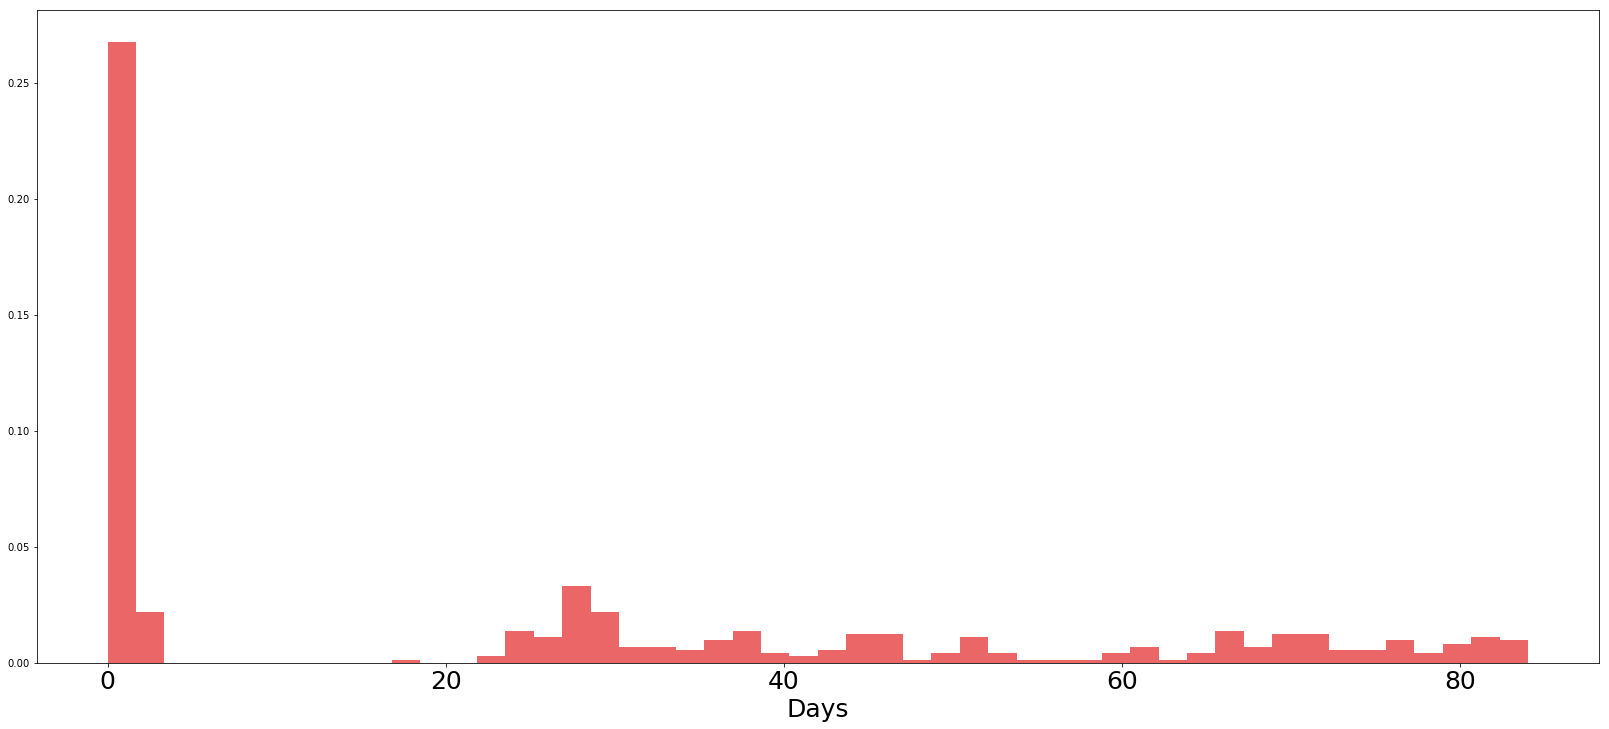

In [142]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

x = arr
plt.rcParams["figure.figsize"] = (28, 12)

n, bins, patches = plt.hist(x, 50, normed=1, facecolor='#e53434', alpha=0.75)
plt.xlabel('Days', fontsize=25)
plt.xticks(fontsize=25)
plt.rcParams['axes.facecolor']='white'
plt.show()

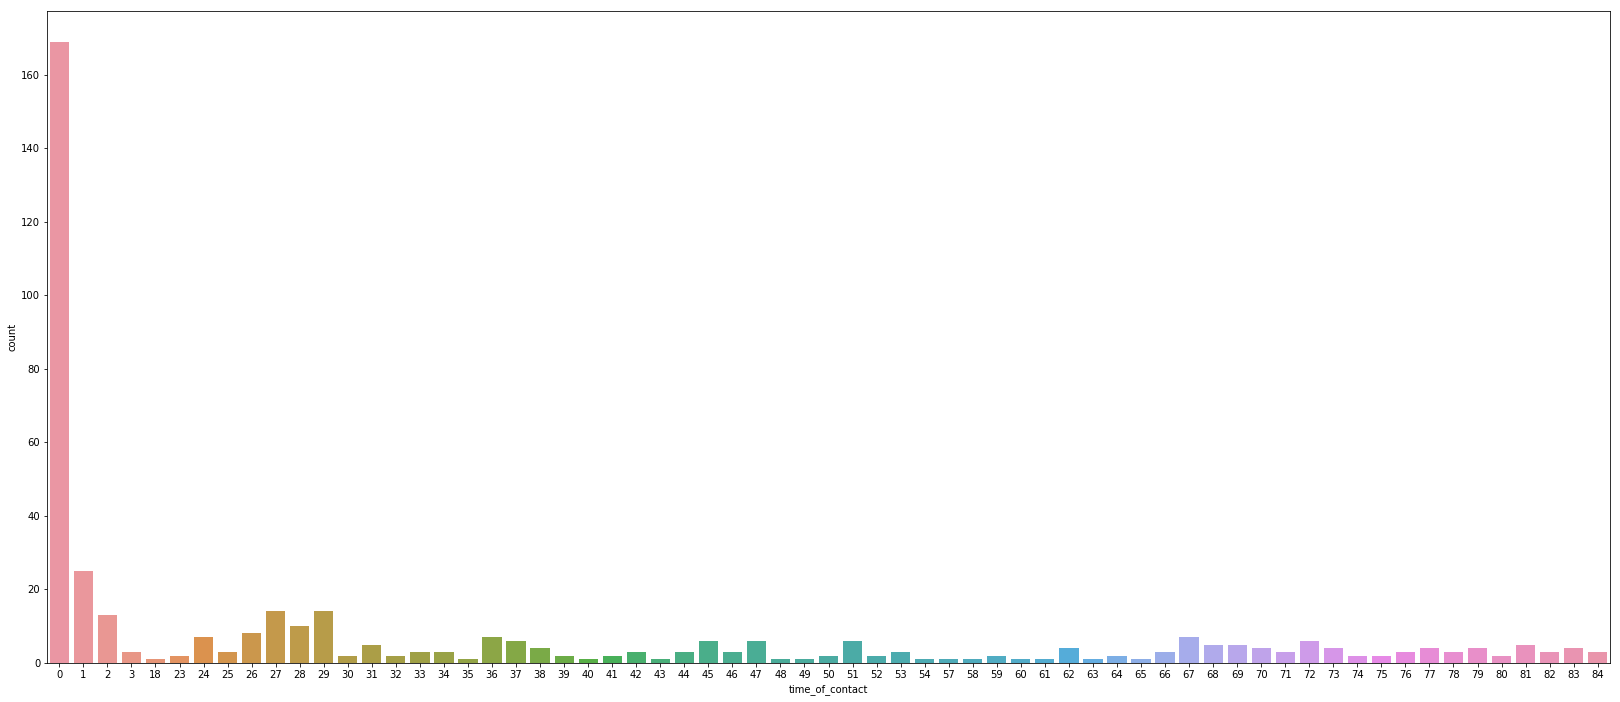

In [143]:
sns.countplot(df_time.time_of_contact.dt.days, )